In [25]:
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::#
#                                                                               #
# Part of solution to exercise set for week 12                                  #
# IN4500 - Machine Learning for Image analysis                                  #
# University of Oslo                                                            #
#                                                                               #
#                                                                               #
# Ole-Johan Skrede    olejohas at ifi dot uio dot no                            #
# 2019.03.31                                                                    #
#                                                                               #
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::#

"""Implements a variational autoencoder"""

import sys
from pathlib import Path
import time

import matplotlib.pyplot as plt
import torch
import torchvision

In [26]:
def config():
    """Return a dict of configuration settings used in the program"""

    conf = {}

    # Whether you are training or testing
    # Values in {'train', 'test_reconstruction', 'test_generation', 'test_interpolation'}
    conf['mode'] = 'train'

    conf['device'] = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    conf['job_dir'] = Path('/tmp/variational_autoencoder/')
    # Relevant dataset will be put in this location after download
    conf['data_dir'] = Path('/tmp/mnist_data')
    # Location to place checkpoints
    conf['checkpoint_dir'] = conf['job_dir'].joinpath('train/checkpoints')
    # Location to place output
    conf['output_dir'] = conf['job_dir'].joinpath('{}/output'.format(conf['mode']))
    # Path of checkpoint you want to restore variables from
    conf['restore_path'] = conf['checkpoint_dir'].joinpath('checkpoint_020000.pt')

    # Create directories
    if not conf['data_dir'].exists():
        conf['data_dir'].mkdir(parents=True)
    if not conf['checkpoint_dir'].exists():
        conf['checkpoint_dir'].mkdir(parents=True)
    if not conf['output_dir'].exists():
        conf['output_dir'].mkdir(parents=True)

    # Number of nodes in the input (the dimensions of an input example)
    conf['height'] = 28
    conf['width'] = 28

    # Implemented: {'cross_entropy', 'mean_squared_error'}
    conf['loss_function'] = 'cross_entropy'
    conf['latent_loss_weight'] = 0.001
    # The number of epochs to run before terminating training
    conf['num_epochs'] = 50
    # The batch size used in training.
    conf['batch_size'] = 128
    # The step size used by the optimization routine.
    conf['learning_rate'] = 1.0e-4

    # How often (in steps) to log the training progress (to stdout)
    conf['monitor_progress'] = 100
    # How often (in steps) to save checkpoints
    conf['periodic_checkpoint'] = 1000
    # How often (in steps) to write reconstruction mosaics during training
    conf['monitor_mosaic'] = 500

    # How many intermediate interpolation results to generate
    conf['num_interpolations'] = 11
    # How many interpolation examples to show
    conf['num_interpolation_examples'] = 10

    # How many test results to show in a plotted mosaic during training and test
    conf['mosaic_height'] = 4
    conf['mosaic_width'] = 5

    return conf


In [27]:
def kl_divergence(mu, log_sigma_squared):
    """
    Computes the KL divergence between two Gaussian distributions p and q

        D_KL(p||q) = sum_x p(x) ( log p(x) / q(x) )

    where

        p ~ N(mu, sigma^2)
        q ~ N(0, 1)
    """
    # Sum over all latent nodes
    return (1.0/2.0 * (mu*mu + log_sigma_squared.exp() - log_sigma_squared - 1.0)).sum(dim=1)

In [28]:
def reconstruction_loss(name, references, predictions):
    """
    Return a loss function value given the input which is expected to be two tensors of the same
    size (examples, dimension). Inputs are expected to have values in (0, 1)
    """
    if name == 'mean_squared_error':
        loss = (references - predictions).pow(2).mean()
    elif name == 'cross_entropy':
        # Binary cross entropy is used to compare the predictions and the reference
        epsilon = 1e-10 # To avoid log(0)
        loss = -(
            references * (epsilon + predictions).log() +
            (1.0 - references) * (epsilon + 1.0 - predictions).log()
            ).mean()
        #loss = loss.mean()
    else:
        print("Please specify an implemented loss function")
        sys.exit(1)
    return loss

In [29]:
def latent_loss(mu, log_sigma_squared):
    """Return latent cost function. Regularizes the spread."""
    return kl_divergence(mu, log_sigma_squared).mean()

In [30]:
class Net(torch.nn.Module):
    """Definition of the variational autoencoder"""

    def __init__(self, conf):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(conf['height'] * conf['width'], 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3_1 = torch.nn.Linear(64, 10)
        self.fc3_2 = torch.nn.Linear(64, 10)
        self.fc4 = torch.nn.Linear(10, 64)
        self.fc5 = torch.nn.Linear(64, 128)
        self.fc6 = torch.nn.Linear(128, conf['height'] * conf['width'])
        self.mu = None
        self.log_sigma_squared = None
        self.latent_vector = None
        self.prediction = None
        self.device = conf['device']


    def encoder(self, x):
        """Encoder part of the variational autoencoder"""
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        self.mu = self.fc3_1(x)
        # We sample log(sigma_squared) in stead of sigma_squared to allow for negative samples
        self.log_sigma_squared = self.fc3_2(x)
        standard_normal = torch.distributions.normal.Normal(
            torch.zeros(self.mu.shape), torch.ones(self.mu.shape)
            ).sample().to(self.device)
        latent_vector = self.mu + standard_normal * self.log_sigma_squared.exp().sqrt()

        return latent_vector


    def decoder(self, x):
        """Decoder part of the variational autoencoder"""
        x = torch.nn.functional.relu(self.fc4(x))
        x = torch.nn.functional.relu(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        return x


    def forward(self, x):
        """Defines one forward pass of the variational autoencoder"""
        self.latent_vector = self.encoder(x)
        self.prediction = self.decoder(self.latent_vector)
        return self.prediction

In [31]:
def plot_mosaic(images, image_height, image_width, mosaic_height, mosaic_width, filename):
    """Write a mosaic of mosaic_height*mosaic_width images to filename"""
    plt.figure(figsize=(mosaic_width, mosaic_height))
    images = images.view(-1, image_height, image_width)
    for ind in range(mosaic_height * mosaic_width):
        image = images[ind, :, :].cpu().detach().numpy()
        plt.subplot(mosaic_height, mosaic_width, ind+1)
        plt.imshow(image, origin='upper', cmap='gray', clim=(0.0, 1.0))
        plt.axis('off')
    plt.savefig(filename)

In [32]:
def plot_interpolation(images, image_height, image_width, filename):
    """Write a row of images to filename"""
    plt.figure(figsize=(len(images), 1))
    for ind, image in enumerate(images):
        plt.subplot(1, len(images), ind+1)
        image = image.view(image_height, image_width)
        image = image.cpu().detach().numpy()
        plt.imshow(image, origin='upper', cmap='gray', clim=(0.0, 1.0))
        plt.axis('off')
    plt.savefig(filename)


In [33]:
def train(conf, model):
    """Train part"""
    data_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(
            conf['data_dir'],
            train=True,
            download=True,
            transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
            ),
        batch_size=conf['batch_size'],
        shuffle=True,
        )
    optimizer = torch.optim.Adam(model.parameters(), lr=conf['learning_rate'])

    running_loss = 0
    total_iter = 0
    prev_time = time.time()
    for epoch_iter in range(1, conf['num_epochs']+1):
        for input_batch, _ in data_loader:
            input_batch = input_batch.to(conf['device'])
            optimizer.zero_grad()
            input_batch = input_batch.view(-1, conf['height'] * conf['width'])
            predictions = model.forward(input_batch)

            loss = (
                reconstruction_loss(conf['loss_function'], input_batch, predictions) +
                conf['latent_loss_weight'] * latent_loss(model.mu, model.log_sigma_squared)
                )

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total_iter += 1
            iter_str = '{:>06}'.format(total_iter)
            # Monitor progress, and store checkpoints
            if total_iter % conf['monitor_progress'] == 0:
                elapsed_time = time.time() - prev_time
                prev_time = time.time()
                images_per_sec = conf['monitor_progress'] * conf['batch_size'] / elapsed_time
                secs_per_step = elapsed_time / conf['monitor_progress']
                print(
                    "Step: {:>6} Epoch: {:>3} Loss: {:>7.4f} Im/sec: {:>7.1f} Sec/step: {:.5f}"
                    .format(
                        total_iter,
                        epoch_iter,
                        running_loss / conf['monitor_progress'],
                        images_per_sec,
                        secs_per_step,
                        )
                    )
                running_loss = 0
            if total_iter % conf['monitor_mosaic'] == 0:
                plot_mosaic(
                    input_batch,
                    conf['height'], conf['width'],
                    conf['mosaic_height'], conf['mosaic_width'],
                    conf['output_dir'].joinpath(iter_str + '_original.png'),
                    )
                plot_mosaic(
                    predictions,
                    conf['height'], conf['width'],
                    conf['mosaic_height'], conf['mosaic_width'],
                    conf['output_dir'].joinpath(iter_str + '_reconstructed.png'),
                    )
            if total_iter % conf['periodic_checkpoint'] == 0:
                ckpt_path = conf['checkpoint_dir'].joinpath('checkpoint_' + iter_str + '.pt')
                print("Writing checkpoint to {}".format(ckpt_path))
                torch.save(model.state_dict(), ckpt_path)


In [34]:
def test_reconstruction(conf, model):
    """Test part"""
    data_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(
            conf['data_dir'],
            train=False,
            download=True,
            transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
            ),
        batch_size=conf['batch_size'],
        shuffle=False,
        )
    model.load_state_dict(torch.load(conf['restore_path']))
    model.eval()
    running_loss = 0
    num_images = 0
    num_iter = 0
    for total_iter, (input_batch, _) in enumerate(data_loader, 1):
        iter_str = "{:>06}".format(total_iter)
        input_batch = input_batch.to(conf['device'])
        input_batch = input_batch.view(-1, conf['height'] * conf['width'])
        predictions = model.forward(input_batch)

        running_loss += (
            reconstruction_loss(conf['loss_function'], input_batch, predictions) +
            conf['latent_loss_weight'] * latent_loss(model.mu, model.log_sigma_squared)
            )

        if total_iter % conf['monitor_mosaic'] == 0:
            print(
                "Eval {:>6} Avg loss {:>6.4f}"
                .format(total_iter * conf['batch_size'], running_loss / total_iter)
                )
            plot_mosaic(
                input_batch,
                conf['height'], conf['width'],
                conf['mosaic_height'], conf['mosaic_width'],
                conf['output_dir'].joinpath(iter_str + '_original.png')
                )
            plot_mosaic(
                predictions,
                conf['height'], conf['width'],
                conf['mosaic_height'], conf['mosaic_width'],
                conf['output_dir'].joinpath(iter_str + '_reconstructed.png')
                )
        num_images += input_batch.shape[0]
        num_iter = total_iter
    print("Finished inference on {} images".format(num_images))
    print("Resulting average loss = {:>6.4f}".format(running_loss / num_iter))

In [35]:
def test_generation(conf, model):
    """Test part"""
    model.load_state_dict(torch.load(conf['restore_path']))
    model.eval()

    # Sample a random tensor of shape batch_size x latent layer size
    latent_vector = torch.distributions.normal.Normal(
        torch.zeros((conf['mosaic_height'] * conf['mosaic_width'], 10)),
        torch.ones((conf['mosaic_height'] * conf['mosaic_width'], 10)),
        ).sample().to(conf['device'])
    predictions = model.decoder(latent_vector)
    plot_mosaic(
        predictions,
        conf['height'], conf['width'],
        conf['mosaic_height'], conf['mosaic_width'],
        conf['output_dir'].joinpath('generated.png'),
        )


In [36]:
def test_interpolation(conf, model):
    """Test part"""
    data_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(
            conf['data_dir'],
            train=False,
            download=True,
            transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
            ),
        batch_size=2,
        shuffle=False,
        )
    model.load_state_dict(torch.load(conf['restore_path']))
    model.eval()
    for total_iter, (input_batch, label_batch) in enumerate(data_loader, 1):
        input_batch = input_batch.to(conf['device'])
        input_batch = input_batch.view(-1, conf['height'] * conf['width'])

        image_1 = input_batch[0, :]
        label_1 = label_batch[0]
        mu_1 = model.encoder(image_1)
        image_1 = image_1.view(conf['height'], conf['width'])

        image_2 = input_batch[1, :]
        label_2 = label_batch[1]
        mu_2 = model.encoder(image_2)
        image_2 = image_2.view(conf['height'], conf['width'])

        interpolations = [image_1]
        for num in range(conf['num_interpolations']):
            weight = num / (conf['num_interpolations'] - 1)
            latent_vector = (1.0 - weight) * mu_1 + weight * mu_2
            prediction = model.decoder(latent_vector)
            prediction = prediction.view(conf['height'], conf['width'])
            interpolations.append(prediction)
        interpolations.append(image_2)

        filename = 'interpolation_{:02}_{}_to_{}.png'.format(total_iter, label_1, label_2)
        plot_interpolation(
            interpolations,
            conf['height'], conf['width'],
            conf['output_dir'].joinpath(filename),
            )
        if total_iter >= conf['num_interpolation_examples']:
            break

Start program
Step:    100 Epoch:   1 Loss:  0.6375 Im/sec:  5760.6 Sec/step: 0.02222
Step:    200 Epoch:   1 Loss:  0.3581 Im/sec:  6611.6 Sec/step: 0.01936
Step:    300 Epoch:   1 Loss:  0.2968 Im/sec:  6677.1 Sec/step: 0.01917
Step:    400 Epoch:   1 Loss:  0.2812 Im/sec:  5797.1 Sec/step: 0.02208
Step:    500 Epoch:   2 Loss:  0.2740 Im/sec:  6510.7 Sec/step: 0.01966
Step:    600 Epoch:   2 Loss:  0.2687 Im/sec:  4018.8 Sec/step: 0.03185
Step:    700 Epoch:   2 Loss:  0.2662 Im/sec:  6412.8 Sec/step: 0.01996
Step:    800 Epoch:   2 Loss:  0.2603 Im/sec:  6374.5 Sec/step: 0.02008
Step:    900 Epoch:   2 Loss:  0.2560 Im/sec:  6393.6 Sec/step: 0.02002
Step:   1000 Epoch:   3 Loss:  0.2523 Im/sec:  6490.9 Sec/step: 0.01972
Writing checkpoint to \tmp\variational_autoencoder\train\checkpoints\checkpoint_001000.pt
Step:   1100 Epoch:   3 Loss:  0.2499 Im/sec:  4251.1 Sec/step: 0.03011
Step:   1200 Epoch:   3 Loss:  0.2471 Im/sec:  6371.3 Sec/step: 0.02009
Step:   1300 Epoch:   3 Loss:  0

C:\Users\anne\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Step:   5600 Epoch:  12 Loss:  0.1789 Im/sec:  4343.4 Sec/step: 0.02947
Step:   5700 Epoch:  13 Loss:  0.1778 Im/sec:  6428.9 Sec/step: 0.01991
Step:   5800 Epoch:  13 Loss:  0.1772 Im/sec:  6537.3 Sec/step: 0.01958
Step:   5900 Epoch:  13 Loss:  0.1758 Im/sec:  6428.9 Sec/step: 0.01991
Step:   6000 Epoch:  13 Loss:  0.1758 Im/sec:  6514.0 Sec/step: 0.01965
Writing checkpoint to \tmp\variational_autoencoder\train\checkpoints\checkpoint_006000.pt
Step:   6100 Epoch:  14 Loss:  0.1759 Im/sec:  4253.9 Sec/step: 0.03009
Step:   6200 Epoch:  14 Loss:  0.1755 Im/sec:  6497.5 Sec/step: 0.01970
Step:   6300 Epoch:  14 Loss:  0.1746 Im/sec:  6567.5 Sec/step: 0.01949
Step:   6400 Epoch:  14 Loss:  0.1736 Im/sec:  6494.2 Sec/step: 0.01971
Step:   6500 Epoch:  14 Loss:  0.1732 Im/sec:  6432.2 Sec/step: 0.01990
Step:   6600 Epoch:  15 Loss:  0.1734 Im/sec:  4747.8 Sec/step: 0.02696
Step:   6700 Epoch:  15 Loss:  0.1724 Im/sec:  6504.1 Sec/step: 0.01968
Step:   6800 Epoch:  15 Loss:  0.1721 Im/sec: 

Step:  15800 Epoch:  34 Loss:  0.1532 Im/sec:  6387.2 Sec/step: 0.02004
Step:  15900 Epoch:  34 Loss:  0.1527 Im/sec:  6390.4 Sec/step: 0.02003
Step:  16000 Epoch:  35 Loss:  0.1533 Im/sec:  6352.4 Sec/step: 0.02015
Writing checkpoint to \tmp\variational_autoencoder\train\checkpoints\checkpoint_016000.pt
Step:  16100 Epoch:  35 Loss:  0.1525 Im/sec:  4109.1 Sec/step: 0.03115
Step:  16200 Epoch:  35 Loss:  0.1522 Im/sec:  6406.4 Sec/step: 0.01998
Step:  16300 Epoch:  35 Loss:  0.1526 Im/sec:  6302.3 Sec/step: 0.02031
Step:  16400 Epoch:  35 Loss:  0.1525 Im/sec:  6448.4 Sec/step: 0.01985
Step:  16500 Epoch:  36 Loss:  0.1529 Im/sec:  6451.6 Sec/step: 0.01984
Step:  16600 Epoch:  36 Loss:  0.1524 Im/sec:  4418.4 Sec/step: 0.02897
Step:  16700 Epoch:  36 Loss:  0.1516 Im/sec:  3912.0 Sec/step: 0.03272
Step:  16800 Epoch:  36 Loss:  0.1516 Im/sec:  3639.5 Sec/step: 0.03517
Step:  16900 Epoch:  37 Loss:  0.1517 Im/sec:  4067.4 Sec/step: 0.03147
Step:  17000 Epoch:  37 Loss:  0.1525 Im/sec: 

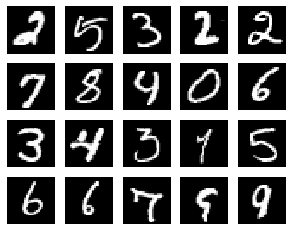

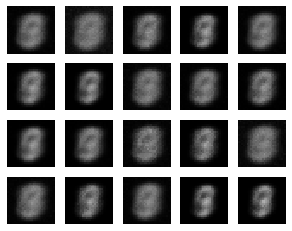

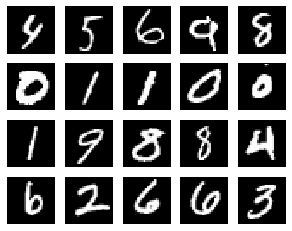

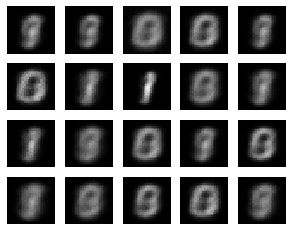

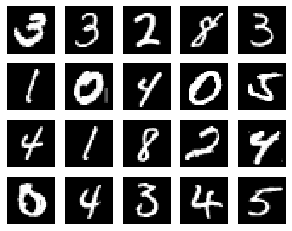

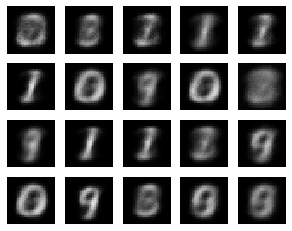

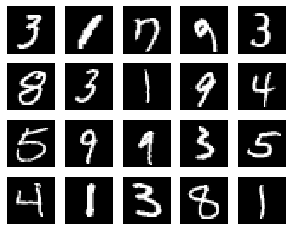

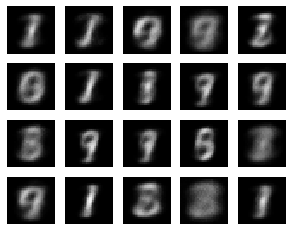

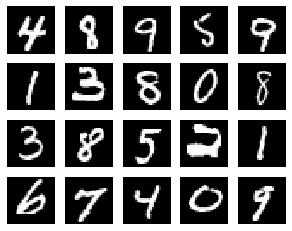

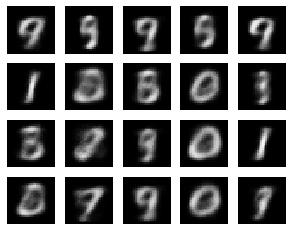

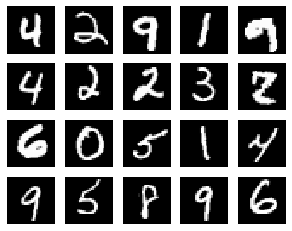

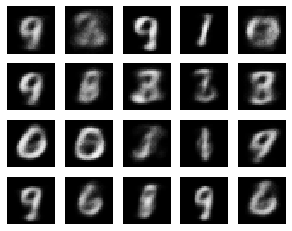

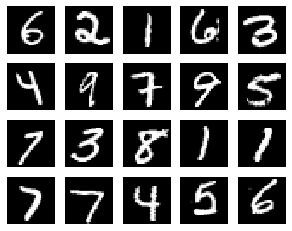

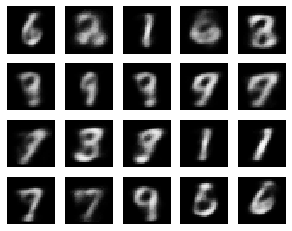

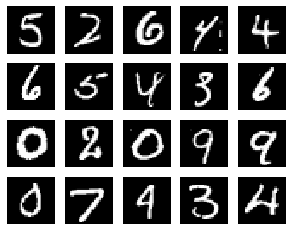

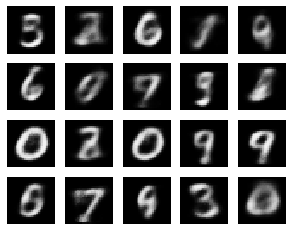

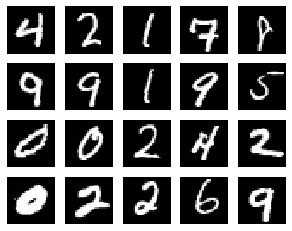

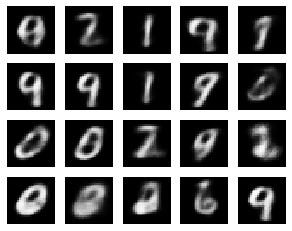

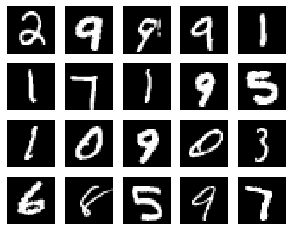

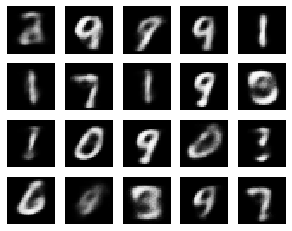

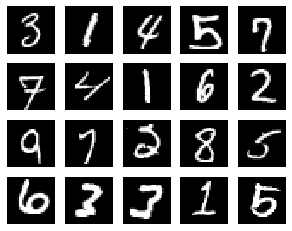

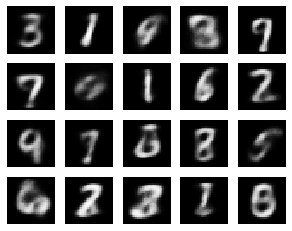

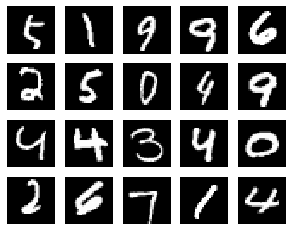

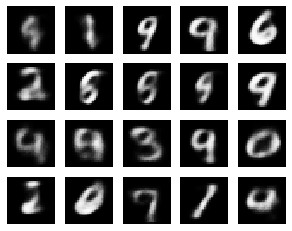

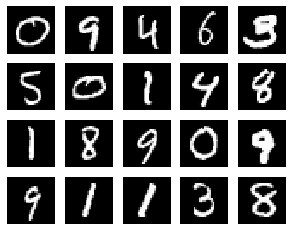

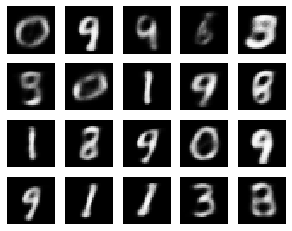

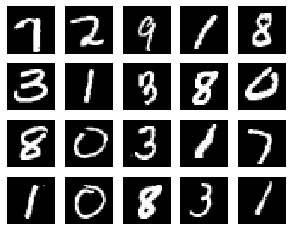

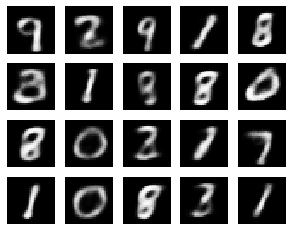

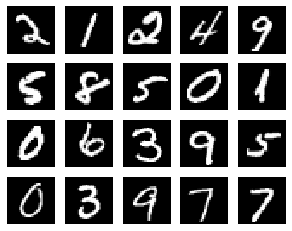

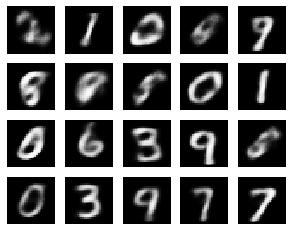

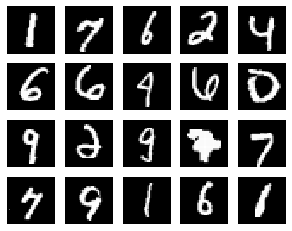

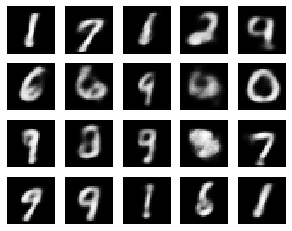

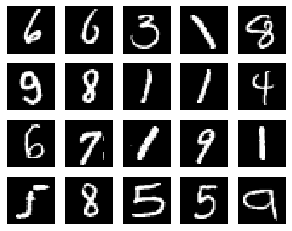

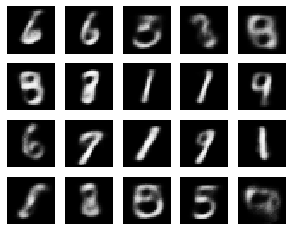

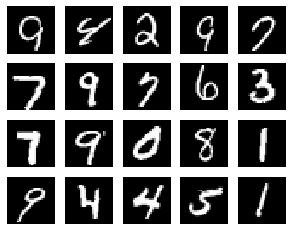

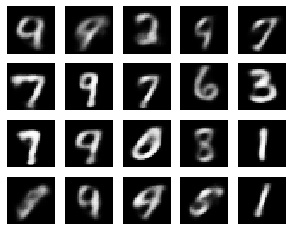

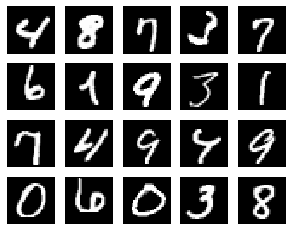

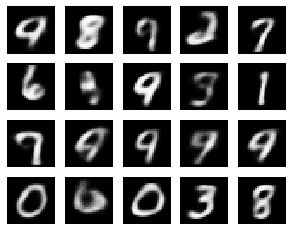

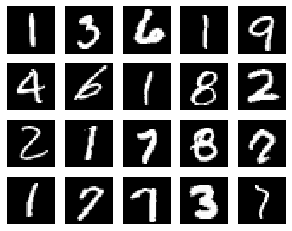

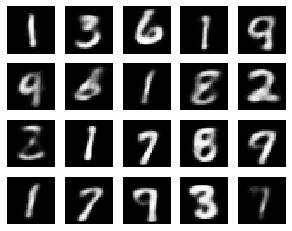

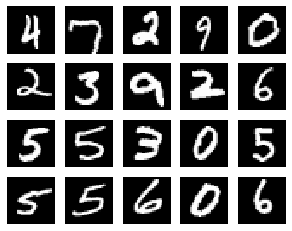

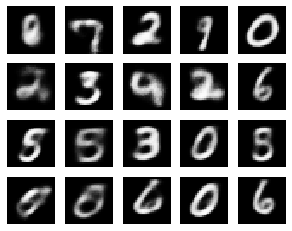

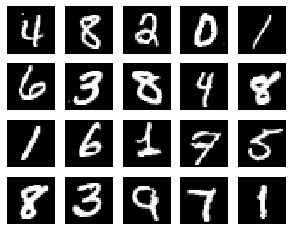

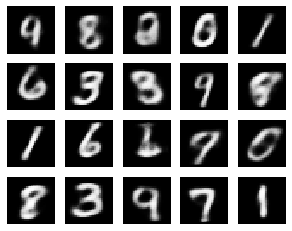

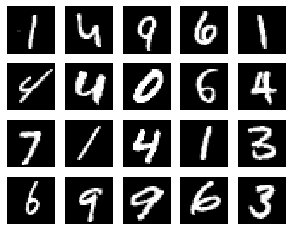

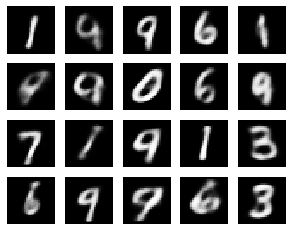

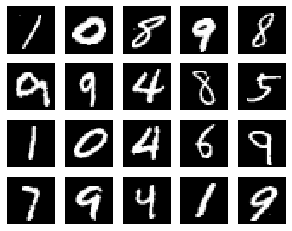

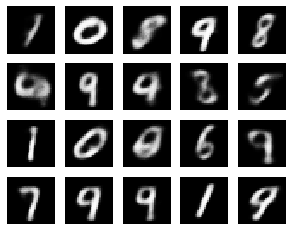

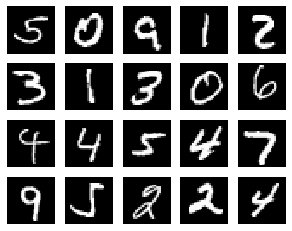

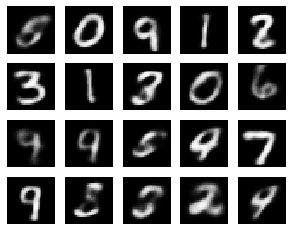

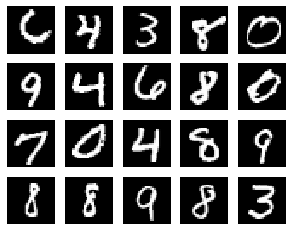

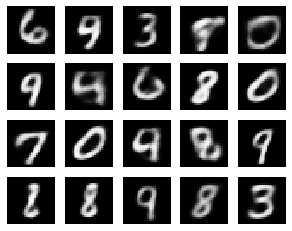

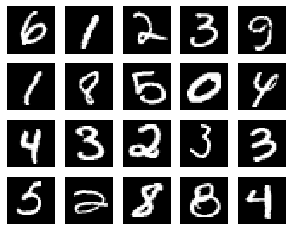

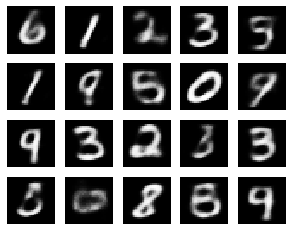

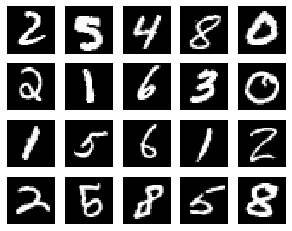

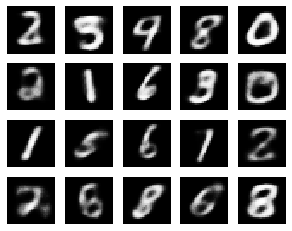

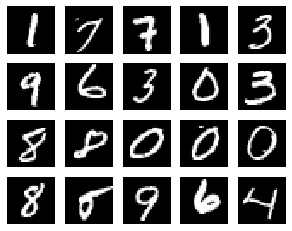

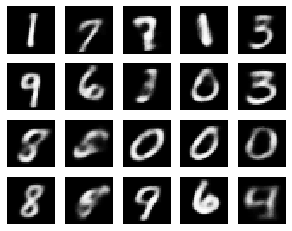

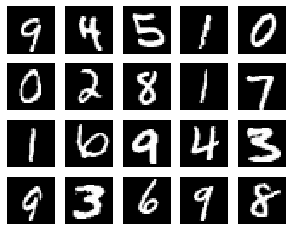

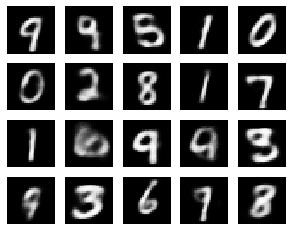

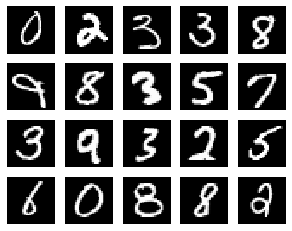

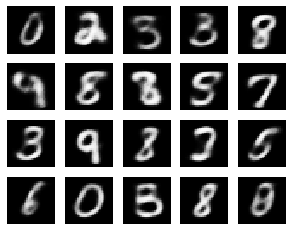

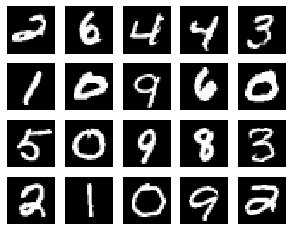

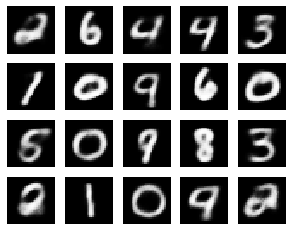

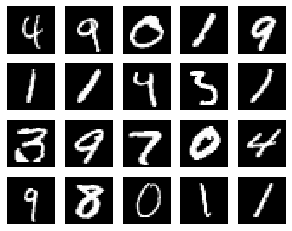

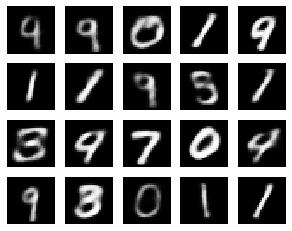

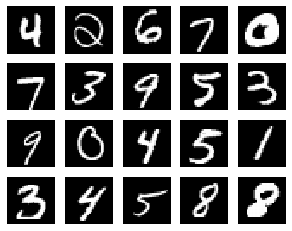

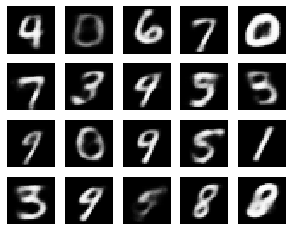

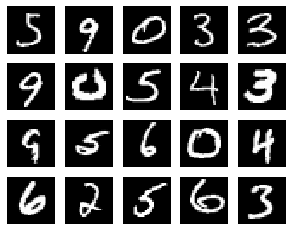

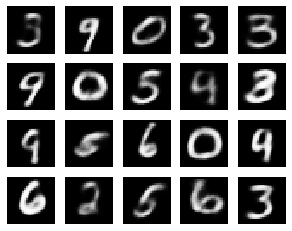

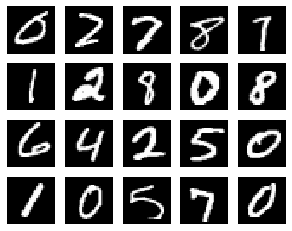

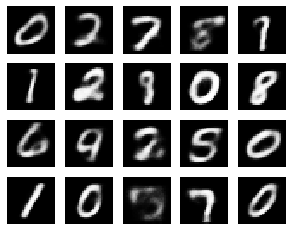

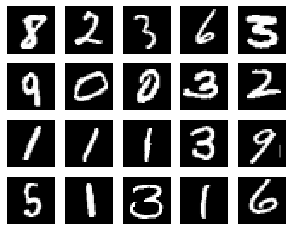

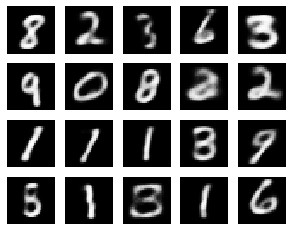

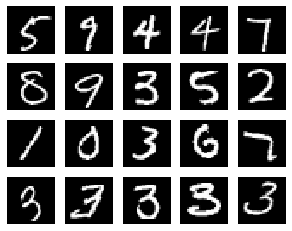

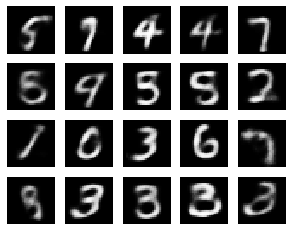

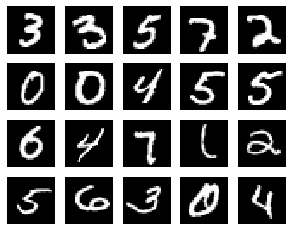

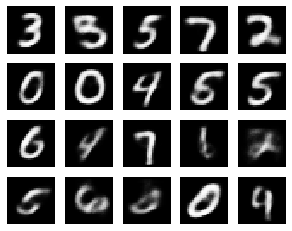

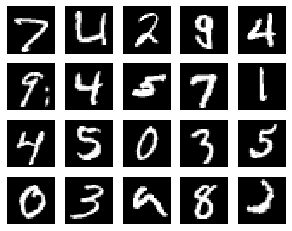

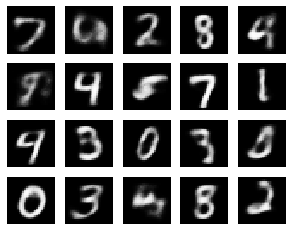

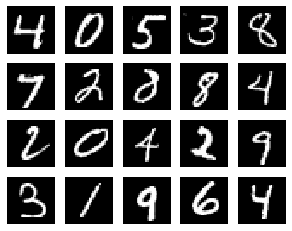

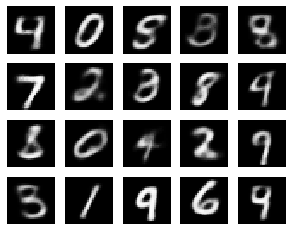

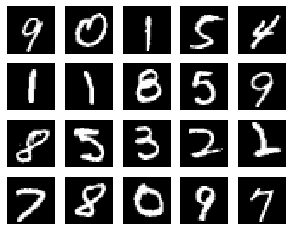

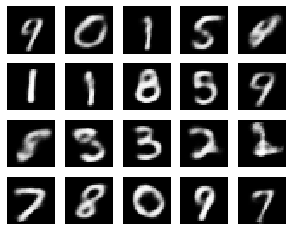

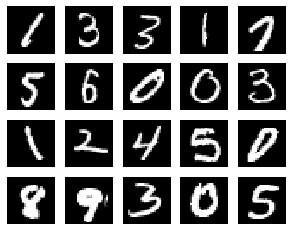

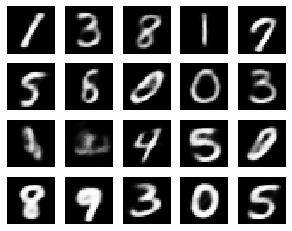

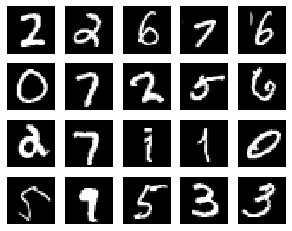

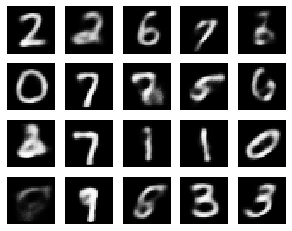

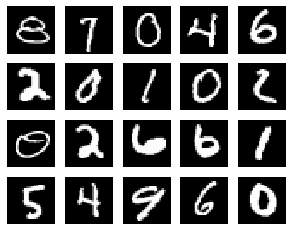

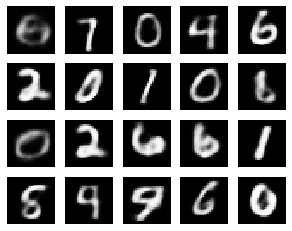

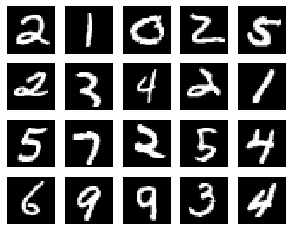

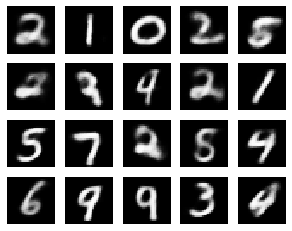

In [37]:
"""Main"""
print("Start program")
conf = config()
model = Net(conf).to(conf['device'])
if conf['mode'] == 'train':
    train(conf, model)
elif conf['mode'] == 'test_reconstruction':
    test_reconstruction(conf, model)
elif conf['mode'] == 'test_generation':
     test_generation(conf, model)
elif conf['mode'] == 'test_interpolation':
    test_interpolation(conf, model)
